In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import cv2
import pickle
import tensorflow as tf

### SegLink Model

In [2]:
from sl_model import SL512
from sl_utils import PriorUtil
from ssd_data import InputGenerator
from ssd_data import preprocess

from utils.model import load_weights

Using TensorFlow backend.


In [3]:
Model = SL512
weights_path = './checkpoints/sl512_ksignboard_ex18/weights.240.h5'
plot_name = 'sl512_crnn_ksignboard'

In [4]:
sl_graph = tf.Graph()
with sl_graph.as_default():
    sl_session = tf.Session()
    with sl_session.as_default():
        model = Model()
        prior_util = PriorUtil(model)
        load_weights(model, weights_path)

image_size = model.image_size

Instructions for updating:
Colocations handled automatically by placer.


### CRNN Model

In [5]:
from crnn_model_focal_ctc_loss import CRNN
#from crnn_utils import alphabet87 as alphabet
from crnn_util2 import dict838 as dic


input_width = 256
input_height = 32
input_shape = (input_width, input_height, 1)

#weights_path = './checkpoints/201905061732_crnn_ksignboard_v18_best_3/weights.053.h5'

crnn_graph = tf.Graph()
with crnn_graph.as_default():
    crnn_session = tf.Session()
    with crnn_session.as_default():
        crnn_model, crnn_model_pred = CRNN(input_shape, len(dic),prediction_only=False, gru=False)
        crnn_model_pred.load_weights("checkpoints/201905061732_crnn_ksignboard_v18_best_3/weights.053.h5",by_name=True)

/home/ina/anaconda3/envs/ina/lib/python3.7/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


### Detection real world images

In [6]:
inputs = []
images = []
images_orig = []
data = []

for img_path in glob.glob('data/images/*.jpg'):
    img = cv2.imread(img_path)
    images_orig.append(np.copy(img))
    inputs.append(preprocess(img, image_size))
    h, w = image_size
    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR).astype('float32') # should we do resizing
    img = img[:, :, (2,1,0)] # BGR to RGB
    img /= 255
    images.append(img)
    
inputs = np.asarray(inputs)

print(inputs.shape)

(2, 512, 512, 3)


In [12]:
with sl_graph.as_default():
    with sl_session.as_default():
        preds = model.predict(inputs, batch_size=2, verbose=1)

2/2 [==============================] - 1s 473ms/step


In [10]:
%%timeit
for i in range(len(inputs)):
    with sl_graph.as_default():
        with sl_session.as_default():
            preds = model.predict(inputs[i:i+1], batch_size=1, verbose=0)
    #res = prior_util.decode(preds[0], segment_threshold, link_threshold)

34.1 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
preds[0].shape

(5461, 31)

In [25]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

#matplotlib 한글 폰트 설정

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=16).get_name()
print(font_name)
plt.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False
fm._rebuild()

NanumGothic Eco


### Recognition

(4, 8)
(4, 5)
lao
아동다
스타벅스커피


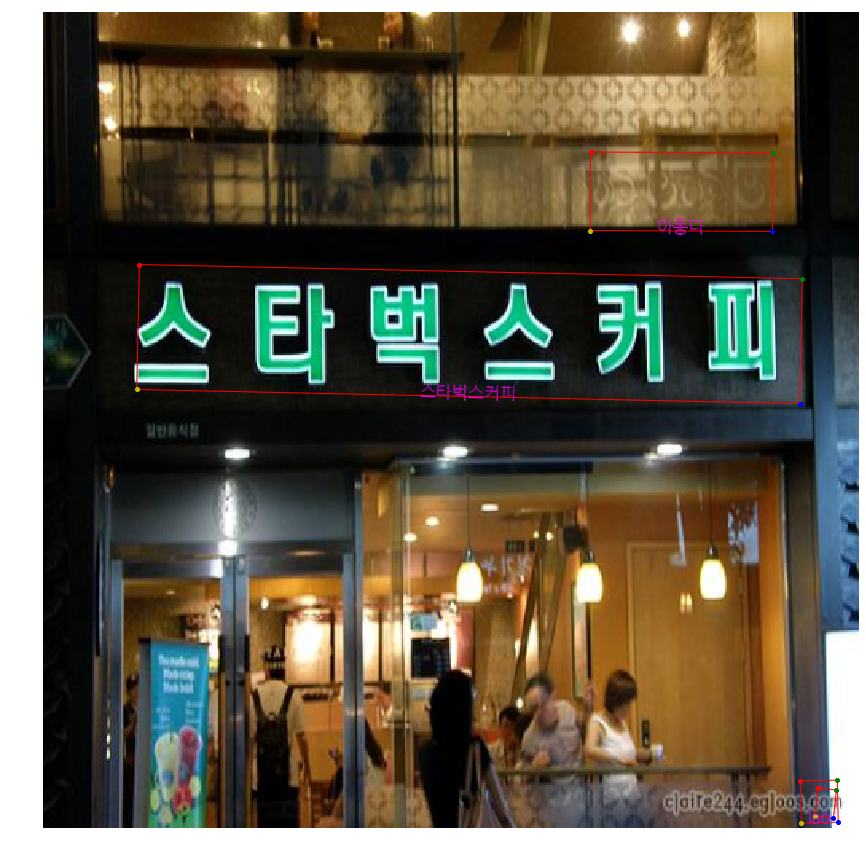

(4, 8)
(4, 5)
20
3120
STARBUCKS COFE


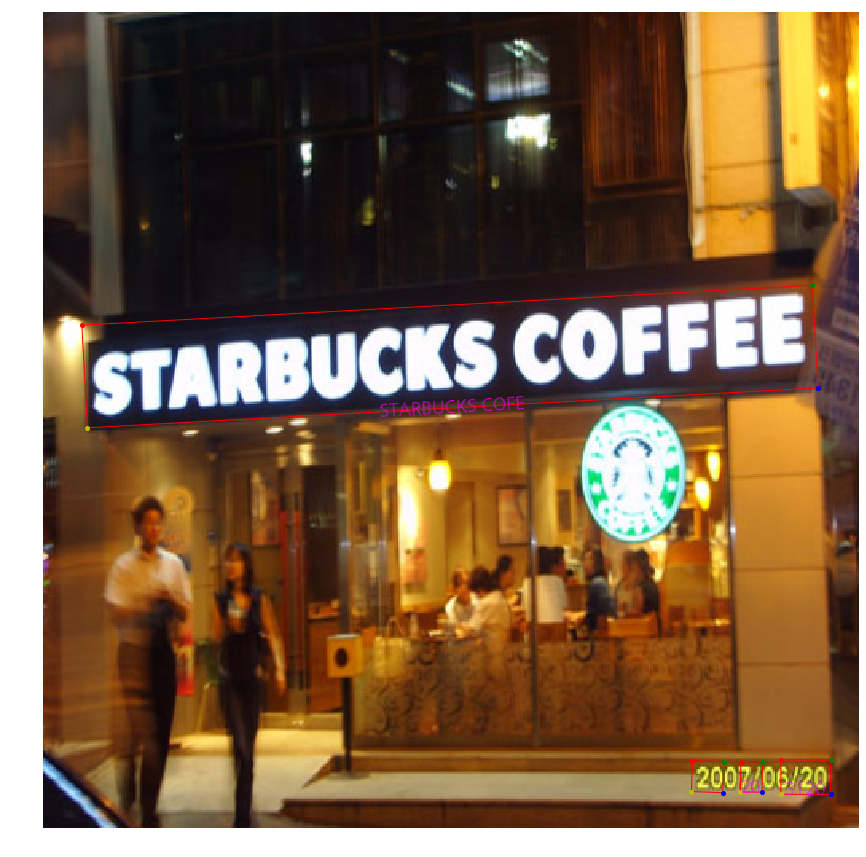

In [31]:
from crnn_data_fcl_aug_merge import crop_words
from crnn_utils import decode
from sl_utils import rbox_to_polygon, polygon_to_rbox
from utils.vis import plot_box, escape_latex

#for k in range(len(preds)):
for k in [0,1]:
    plt.figure(figsize=[15]*2)
    plt.imshow(images[k])
    res = prior_util.decode(preds[k], segment_threshold, link_threshold)
    
    #print(res.shape)
    
    img = images_orig[k]
    #mean = np.array([104,117,123])
    #img -= mean[np.newaxis, np.newaxis, :]
    rboxes = res[:,:5]
    if len(rboxes) == 0:
        plt.axis('off')
        plt.show()
        continue
        
    bh = rboxes[:,3]
    rboxes[:,2] += bh * 0.1
    rboxes[:,3] += bh * 0.2
    
    boxes = np.asarray([rbox_to_polygon(r) for r in rboxes])
    boxes = np.flip(boxes, axis=1) # TODO: fix order of points, why?
    boxes = np.reshape(boxes, (-1, 8))
    
    boxes_mask = np.array([not (np.any(b < 0-10) or np.any(b > 512+10)) for b in boxes]) # box inside image
    #boxes_mask = np.logical_and(boxes_mask, [b[2] > 0.8*b[3] for b in rboxes]) # width > height, in square world
    
    boxes = boxes[boxes_mask]
    rboxes = rboxes[boxes_mask]
    if len(boxes) == 0:
        boxes = np.empty((0,8))
        
    print(boxes.shape)
    print(rboxes.shape)
    
    # plot boxes
    for box in boxes:
        c = 'rgby'
        for i in range(4):
            x, y = box[i*2:i*2+2]
            plt.plot(x,y, c[i], marker='o', markersize=4)
        plot_box(box, 'polygon')
    
    words = crop_words(img, np.clip(boxes/512,0,1), input_height, width=input_width, grayscale=True)
    
    words = np.asarray([w.transpose(1,0,2) for w in words[0]])
    
    if len(words) > 0:
        with crnn_graph.as_default():
            with crnn_session.as_default():
                    res_crnn = crnn_model_pred.predict(words)

    #print('rboxes', len(rboxes), 'words', len(words), 'res_crnn', len(res_crnn))
    for i in range(len(words)):
        chars = [dic[c] for c in np.argmax(res_crnn[i], axis=1)]
        
        #gt_str = texts[i]
        res_str = decode(chars)
        print(res_str)
        
        #ed = editdistance.eval(gt_str, res_str)
        #ed = levenshtein(gt_str, res_str)
        #ed_norm = ed / len(gt_str)
        #mean_ed += ed
        #mean_ed_norm += ed_norm
        
        #print('%-20s %s' % (res_str, ''.join(chars)))
        #print('%s %-20s %0.2f' % (''.join(chars), res_str, res[i,5]))
        
        #print('%-20s %-20s %s %0.2f' % (
        #    gt_str,
        #    res_str,
        #    ''.join(chars),
        #    ed_norm))
        x, y, w, h, theta = rboxes[i+1]
        
        #res_str = re.sub(r"([#$%&_{}])", r"\\\1" , res_str)
        #print(res_str, '   ', escape_latex(res_str))
        
        #print(escape_latex(res_str))
        
        
        #plt.text(x+h*np.sin(theta)/2, y+h*np.cos(theta)/2, escape_latex(res_str), rotation=theta/np.pi*180, 
        #         horizontalalignment='center', size='x-large' , color='cyan') # magenta, lime
        plt.text(x+h*np.sin(theta)/2, y+h*np.cos(theta)/2, escape_latex(res_str), rotation=theta/np.pi*180, 
                 horizontalalignment='center', size='xx-large' , color='magenta') # magenta, lime
    
    plt.axis('off')
    
    file_name = 'plots/%s_endtoend_realworld_%03i.pgf' % (plot_name, k)
    #plt.savefig(file_name, bbox_inches='tight')
    #print(file_name)
    
    plt.show()
    
    if False:
        for i in range(len(words)):
            plt.figure(figsize=[30,0.5])
            plt.imshow(words[i][:,:,0].T, cmap='gray')
            plt.axis('off')
            plt.show()